# **Importing the Required Libraries**

In [21]:
import os
import cv2
import numpy as np

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.cluster.vq import vq
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

**Mounting Google Drive**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Functions**

**Function to extract features using SIFT detector**

In [23]:
def extract_sift_features(img):
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

**Function to calculate BoW representation of images**

In [24]:
def calculate_bow(descriptors, vocabulary):
    bow_hist = np.zeros((1, len(vocabulary)), dtype=np.float32)
    if descriptors is not None:
        # Find nearest cluster center for each descriptor using k-means clustering
        words, _ = vq(descriptors, vocabulary)
        # Count occurrences of each word in the vocabulary
        for w in words:
            bow_hist[0][w] += 1
    return bow_hist

**Function to Display Confusion Matrix**

In [25]:
def showconfusionmatrix(cm):
    # Display the confusion matrix as a heatmap
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Calculate TP, TN, FP, and FN using NumPy
    tn = cm.sum(axis=0) - np.diag(cm)  # Sum of all non-diagonal elements in each column
    fp = cm.sum(axis=1) - np.diag(cm)  # Sum of all non-diagonal elements in each row
    fn = np.diag(cm)  # Diagonal elements of the matrix
    tp = cm.sum() - (tn + fp + fn)  # Total number of elements minus all other values

    print("True Positives:", tp)
    print("False Positives:", fp)

# **Loading the Dataset**

**Saving Paths and Feature Extraction**

In [26]:
objects_path =  '/content/drive/MyDrive/Objects_Dataset_Images/'

In [27]:
dataset_images = []
dataset_labels = []
train_path = []

**For Training Data**

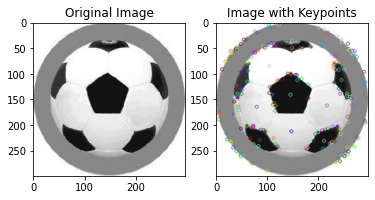

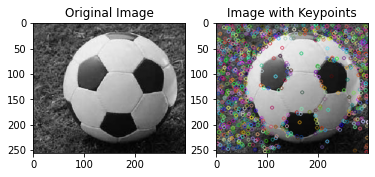

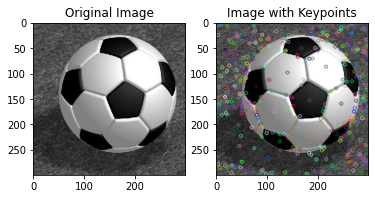

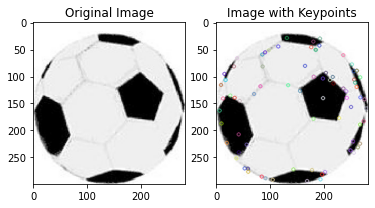

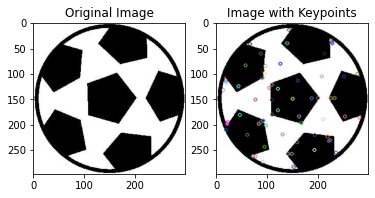

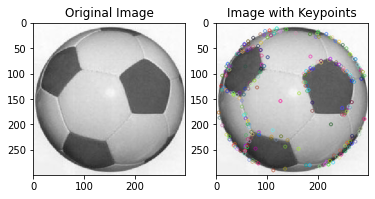

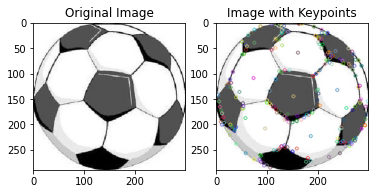

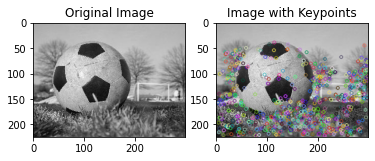

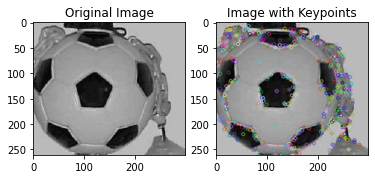

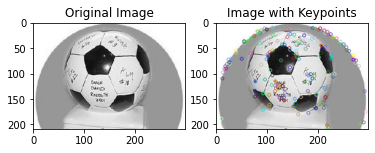

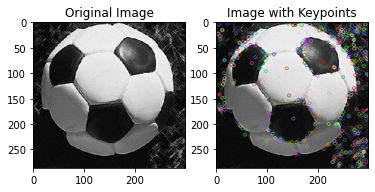

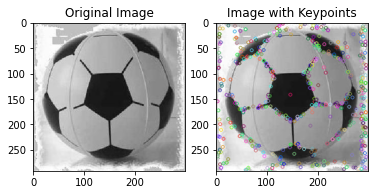

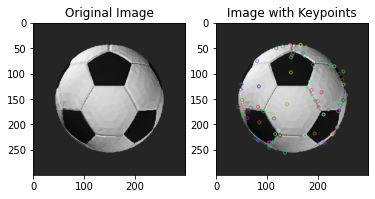

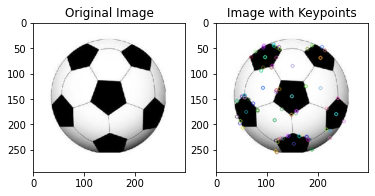

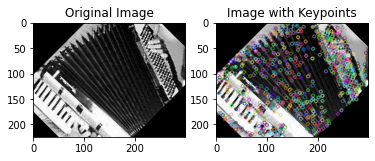

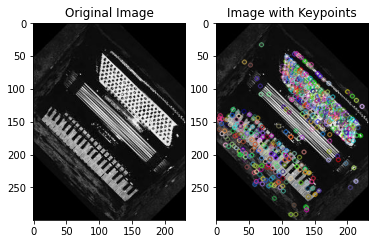

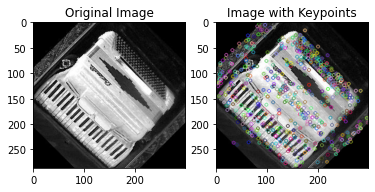

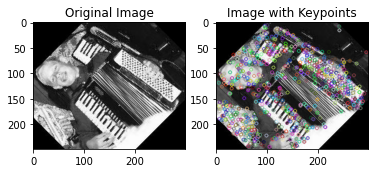

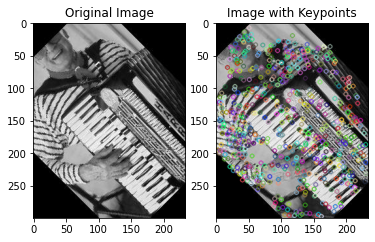

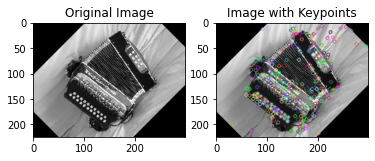

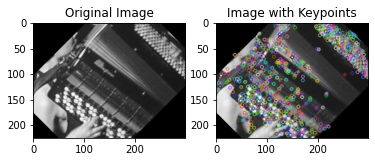

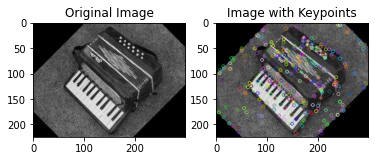

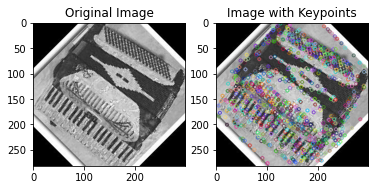

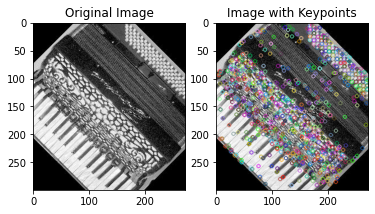

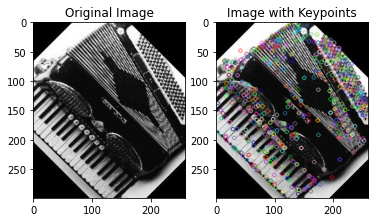

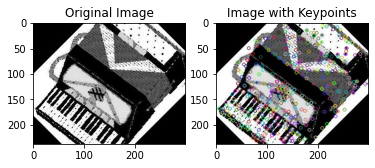

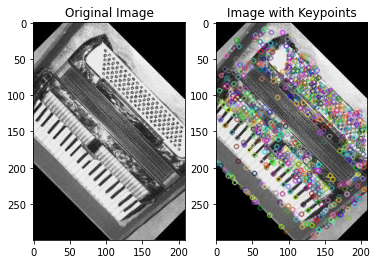

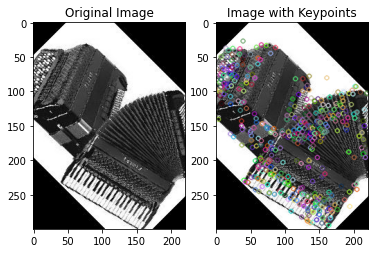

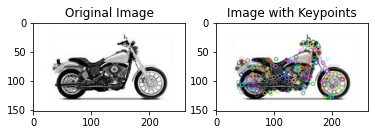

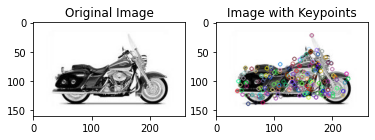

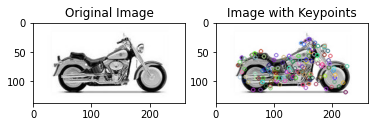

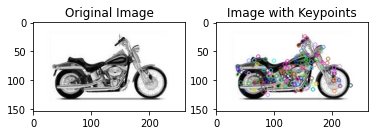

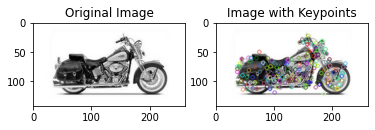

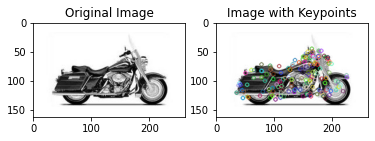

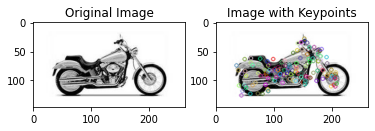

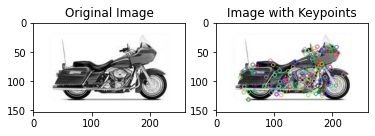

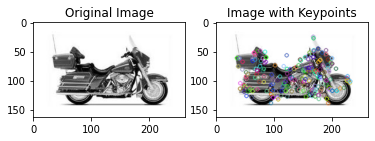

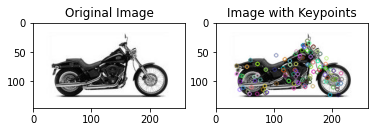

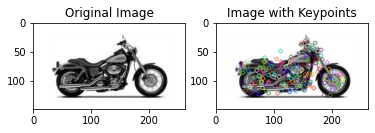

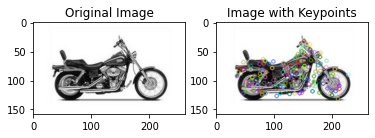

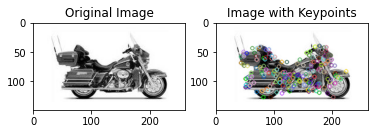

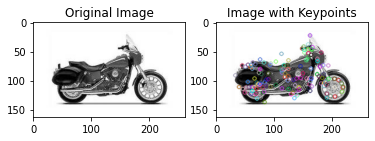

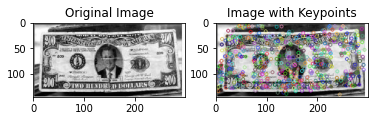

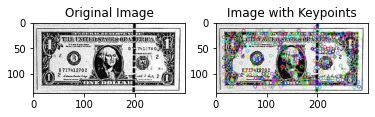

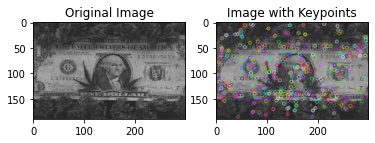

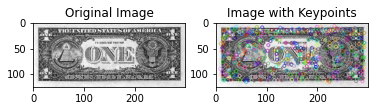

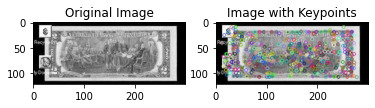

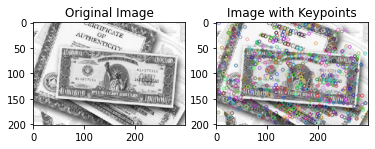

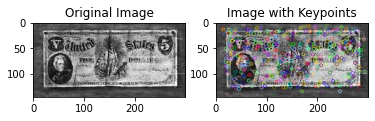

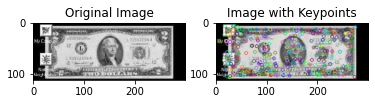

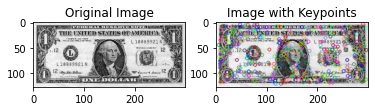

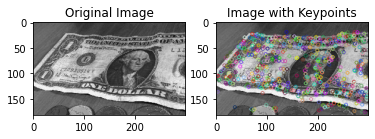

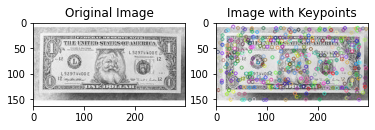

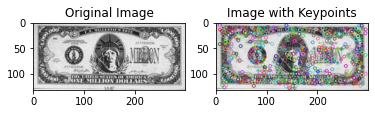

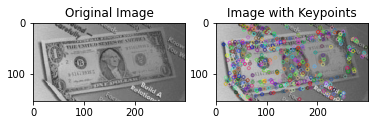

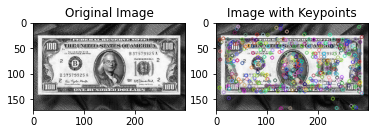

In [28]:
for class_name in os.listdir(objects_path + "/train/"):
    class_path = objects_path + "/train/" + class_name + "/"
    for img_file in os.listdir(class_path):
        img_path = class_path + img_file

        train_path.append(img_path)

        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)

        # Resize the image using cv2.resize
        resized_image = cv2.resize(img, (90, 90))

        keypoint, descriptor = extract_sift_features(img) #extracting features
        dataset_images.append(descriptor)
        dataset_labels.append(class_name)

        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # Show the original image in the first subplot
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')

        # Show the image with keypoints in the second subplot
        img_keypoints = cv2.drawKeypoints(img, keypoint, None)
        ax2.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
        ax2.set_title('Image with Keypoints')

        # Display the figure
        plt.show()

# **Codebook Generation using Kmeans**

In [29]:
num_clusters = 200 # Set number of clusters
descriptors = np.vstack(dataset_images)
kmeans = KMeans(n_clusters=num_clusters)
vocabulary = kmeans.fit(descriptor).cluster_centers_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Calculate BoVW Histogram**

In [30]:
dataset_train_bow = []
dataset_test_bow = []

In [31]:

#for class_name in os.listdir(objects_path + "/train/"):
#    class_path = objects_path + "/train/" + class_name + "/"
#    for img_file in os.listdir(class_path):
#        img_path = class_path + img_file
#        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#        kp, des = extract_sift_features(img)
#        bow_hist = calculate_bow(des, vocabulary)
#        dataset_train_bow.append(bow_hist)
for img_path in train_path:
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  kp, des = extract_sift_features(img)
  bow_hist = calculate_bow(des, vocabulary)
  dataset_train_bow.append(bow_hist)

for class_name in os.listdir(objects_path + "/test/"):
    class_path = objects_path + "/test/" + class_name + "/"
    for img_file in os.listdir(class_path):
        img_path = class_path + img_file
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        kp, des = extract_sift_features(img)
        bow_hist = calculate_bow(des, vocabulary)
        dataset_test_bow.append(bow_hist)

**Plot the Histogram**

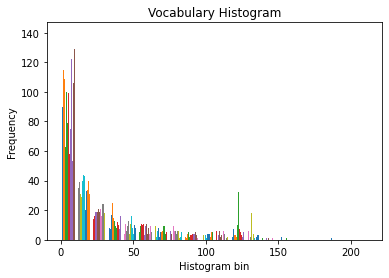

In [32]:
# Plot the histogram
plt.hist(vocabulary, bins=20)
plt.title("Vocabulary Histogram")
plt.xlabel("Histogram bin")
plt.ylabel("Frequency")
plt.show()

**Split dataset into train and test sets**

In [33]:
X_train = np.array(dataset_train_bow)
y_train = np.array(dataset_labels)
X_test = np.array(dataset_test_bow)
y_test = np.array([class_name for class_name in os.listdir(objects_path + "/test/") for i in range(len(os.listdir(objects_path + "/test/" + class_name)))])

# **SVM classifier**

**Training SVM**

In [34]:
# Train SVM classifier on Objects dataset
svm = SVC(kernel='linear', C=1.0, probability=True)
svm.fit(X_train.reshape(X_train.shape[0], -1), y_train)

SVC(kernel='linear', probability=True)

**Testing SVM**

In [35]:
# Make predictions on the test set and evaluate the accuracy
y_pred_svm = svm.predict(X_test.reshape(X_test.shape[0], -1))

**Accuracy**

In [36]:
accuracy = accuracy_score(y_test, y_pred_svm )
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 75.00%


**F1 Score**

In [37]:
# Calculate the F1 score when avaerage is none
f1 = f1_score(y_test, y_pred_svm ,average=None)
print("F1 score:", f1)

# Calculate the F1 score using weighted average
f1 = f1_score(y_test, y_pred_svm , average='weighted')
print("F1 score: {:.2f}".format(f1))

F1 score: [0.66666667 0.66666667 1.         0.66666667]
F1 score: 0.75


**Confusion Matrix of SVM**

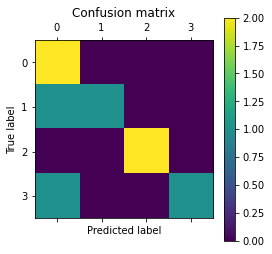

True Positives: [4 6 6 6]
False Positives: [0 1 0 1]


In [38]:
conf_mat = confusion_matrix(y_test, y_pred_svm)
showconfusionmatrix(conf_mat)

# **Random Forrest Classification**

**Training**

In [39]:
# Train a random forest classifier on the training set
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train.reshape(X_train.shape[0], -1), y_train)

RandomForestClassifier(random_state=42)

**Testing**

In [40]:
# Make predictions on the test set and evaluate the accuracy
y_pred_rfc = rfc.predict(X_test.reshape(X_test.shape[0], -1))

**Accuracy**

In [41]:
accuracy = accuracy_score(y_test, y_pred_rfc)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 87.50%


**F1 Score**

In [42]:

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_rfc,average=None)
print("F1 score: ", f1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_rfc, average='weighted')
print("F1 score: {:.2f}".format(f1))

F1 score:  [0.8        1.         1.         0.66666667]
F1 score: 0.87


**Confusion Matrix**

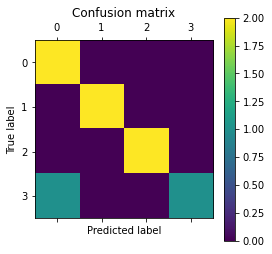

True Positives: [5 6 6 6]
False Positives: [0 0 0 1]


In [43]:
conf_mat = confusion_matrix(y_test, y_pred_rfc)
showconfusionmatrix(conf_mat)